# 🚀 Mini-Projet : Pipeline de Preprocessing Complet

## 🎯 Analyseur de Sentiment pour TechShop France

**Module 2** - Preprocessing et Tokenisation

**Durée estimée :** 3-4 heures

---

### 📋 Contexte du Projet

Vous travaillez pour **TechShop France**, un site e-commerce spécialisé en high-tech. L'équipe marketing souhaite analyser automatiquement les milliers de commentaires clients pour :

- 📊 Identifier les produits les mieux notés
- 😟 Détecter les problèmes récurrents
- 💡 Améliorer l'expérience client
- 🎯 Personnaliser les recommandations

### 🎓 Objectifs d'Apprentissage

À la fin de ce projet, vous saurez :
1. ✅ Construire un pipeline de preprocessing modulaire et réutilisable
2. ✅ Gérer les spécificités du français (accents, apostrophes, expressions)
3. ✅ Optimiser les performances sur de gros volumes de données
4. ✅ Mesurer l'impact du preprocessing sur la qualité des résultats
5. ✅ Visualiser et communiquer vos résultats

---

## 📚 1. Imports et Configuration

Commençons par importer toutes les bibliothèques nécessaires et configurer notre environnement de travail.

In [20]:
# Imports standards

!pip install wordcloud
!pip install scikit-learn

import re
import string
import unicodedata
from collections import Counter, defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configuration pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ Environnement configuré avec succès !")
print(f"📊 Pandas version : {pd.__version__}")
print(f"📈 NumPy version : {np.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 24.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]
✅ Environnement configuré avec succès !
📊 Pandas version : 2.2.3
📈 NumPy version : 2.2.2


## 📥 2. Chargement et Exploration des Données

### 2.1 Génération du Dataset

Pour ce projet, nous allons créer un dataset réaliste de commentaires clients e-commerce.

In [21]:
# Génération d'un dataset de commentaires clients réalistes
np.random.seed(42)  # Pour la reproductibilité

# Templates de commentaires positifs
commentaires_positifs = [
    "Super produit !!! Je le recommande à 100% 👍",
    "Livraison rapide et produit conforme à la description. Très satisfait !",
    "Excellent rapport qualité/prix. J'ai acheté ce produit il y a 3 mois, toujours nickel",
    "TOP ! Correspond parfaitement à mes attentes 😊",
    "Très bon produit, emballage soigné. Site sérieux à recommander",
    "J'ADORE !!! Exactement ce que je cherchais. Merci TechShop",
    "Produit de qualité, livraison en 24h. Que demander de plus ?",
    "5 étoiles ! Installation facile et fonctionne parfaitement",
    "Vraiment content de mon achat. Prix correct pour cette qualité",
    "Nickel ! Conforme à la description et arrivé rapidement"
]

# Templates de commentaires négatifs
commentaires_negatifs = [
    "Déçu... Le produit ne correspond pas du tout à la description 😞",
    "ARNAQUE !!! N'achetez surtout pas, qualité médiocre",
    "Livraison en retard et produit défectueux. Service client inexistant",
    "Nul ! Tombé en panne après 2 semaines... Je déconseille",
    "Très mauvaise expérience. Produit cassé à la réception",
    "Attention FAKE ! Ce n'est pas le produit original",
    "Bof bof... Qualité moyenne et prix trop élevé",
    "Problème dès la première utilisation. SAV injoignable",
    "Je regrette mon achat. Le produit ne fonctionne pas correctement",
    "Décevant... J'attendais mieux pour ce prix 😤"
]

# Templates de commentaires neutres
commentaires_neutres = [
    "Produit correct, sans plus. Fait le job",
    "Moyen... Quelques défauts mais utilisable",
    "Pas mal mais j'ai vu mieux ailleurs pour le même prix",
    "Livraison ok, produit ok. RAS",
    "Ça va, conforme mais rien d'exceptionnel",
    "Bien mais pas top. Quelques finitions à revoir",
    "Satisfait mais sans plus. Prix un peu élevé",
    "Correct pour le prix. Ne pas s'attendre à du haut de gamme",
    "Fait ce qu'on lui demande, point",
    "Acceptable mais j'espérais mieux"
]

# Fonction pour ajouter du bruit réaliste
def ajouter_bruit(commentaire):
    """Ajoute des éléments réalistes aux commentaires"""
    # URLs aléatoires
    if np.random.rand() > 0.9:
        urls = ["https://bit.ly/xyz", "www.techshop.fr/promo", "http://example.com"]
        commentaire += f" {np.random.choice(urls)}"
    
    # Emails
    if np.random.rand() > 0.95:
        commentaire += " contact: service@techshop.fr"
    
    # Hashtags
    if np.random.rand() > 0.8:
        hashtags = [" #tech", " #hightech", " #promo", " #soldes", " #blackfriday"]
        commentaire += np.random.choice(hashtags)
    
    # Fautes de frappe et espaces
    if np.random.rand() > 0.7:
        commentaire = commentaire.replace(" ", "  ")
    
    # Prix
    if np.random.rand() > 0.85:
        prix = np.random.randint(10, 500)
        commentaire += f" ({prix}€)"
    
    return commentaire

# Génération du dataset
data = []
n_samples = 1000

# Distribution : 40% positifs, 35% négatifs, 25% neutres
for i in range(n_samples):
    rand = np.random.rand()
    if rand < 0.4:
        commentaire = np.random.choice(commentaires_positifs)
        sentiment = "positif"
        note = np.random.choice([4, 5], p=[0.3, 0.7])
    elif rand < 0.75:
        commentaire = np.random.choice(commentaires_negatifs)
        sentiment = "negatif"
        note = np.random.choice([1, 2], p=[0.6, 0.4])
    else:
        commentaire = np.random.choice(commentaires_neutres)
        sentiment = "neutre"
        note = 3
    
    # Ajouter des variations
    commentaire = ajouter_bruit(commentaire)
    
    # Catégorie de produit
    categories = ["Smartphone", "Ordinateur", "Tablette", "Accessoires", "Audio"]
    categorie = np.random.choice(categories, p=[0.3, 0.25, 0.2, 0.15, 0.1])
    
    data.append({
        'id': f'COM_{i:04d}',
        'commentaire': commentaire,
        'sentiment': sentiment,
        'note': note,
        'categorie': categorie,
        'date': pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 365))
    })

# Création du DataFrame
df = pd.DataFrame(data)
print(f"✅ Dataset créé avec {len(df)} commentaires")
print(f"\n📊 Aperçu des données :")
df.head()

✅ Dataset créé avec 1000 commentaires

📊 Aperçu des données :


,id,commentaire,sentiment,note,categorie,date
0,COM_0000,5 étoiles ! Installation facile et fonctionne parfaitement,positif,5,Tablette,2024-05-29
1,COM_0001,5 étoiles ! Installation facile et fonctionne parfaitement,positif,5,Ordinateur,2024-02-18
2,COM_0002,Décevant... J'attendais mieux pour ce prix 😤 http://example.com,negatif,1,Tablette,2024-05-10
3,COM_0003,Satisfait mais sans plus. Prix un peu élevé #soldes,neutre,3,Smartphone,2024-12-05
4,COM_0004,"Produit de qualité, livraison en 24h. Que demander de plus ?",positif,5,Ordinateur,2024-02-23


### 2.2 Analyse Exploratoire

Explorons notre dataset pour mieux comprendre les données.

In [22]:
# Informations générales
print("📊 INFORMATIONS GÉNÉRALES")
print("=" * 50)
print(f"Nombre total de commentaires : {len(df)}")
print(f"Période : {df['date'].min().strftime('%Y-%m-%d')} à {df['date'].max().strftime('%Y-%m-%d')}")
print(f"\nNombre de valeurs manquantes :")
print(df.isnull().sum())

# Distribution des sentiments
print("\n🎭 DISTRIBUTION DES SENTIMENTS")
print("=" * 50)
sentiment_counts = df['sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment.capitalize()} : {count} ({count/len(df)*100:.1f}%)")

# Distribution des notes
print("\n⭐ DISTRIBUTION DES NOTES")
print("=" * 50)
note_counts = df['note'].value_counts().sort_index()
for note, count in note_counts.items():
    stars = "⭐" * note
    print(f"{stars} : {count} ({count/len(df)*100:.1f}%)")

# Distribution des catégories
print("\n📱 DISTRIBUTION DES CATÉGORIES")
print("=" * 50)
for cat, count in df['categorie'].value_counts().items():
    print(f"{cat} : {count} ({count/len(df)*100:.1f}%)")

📊 INFORMATIONS GÉNÉRALES
Nombre total de commentaires : 1000
Période : 2024-01-01 à 2024-12-30

Nombre de valeurs manquantes :
id             0
commentaire    0
sentiment      0
note           0
categorie      0
date           0
dtype: int64

🎭 DISTRIBUTION DES SENTIMENTS
Positif : 378 (37.8%)
Negatif : 348 (34.8%)
Neutre : 274 (27.4%)

⭐ DISTRIBUTION DES NOTES
⭐ : 215 (21.5%)
⭐⭐ : 133 (13.3%)
⭐⭐⭐ : 274 (27.4%)
⭐⭐⭐⭐ : 115 (11.5%)
⭐⭐⭐⭐⭐ : 263 (26.3%)

📱 DISTRIBUTION DES CATÉGORIES
Smartphone : 295 (29.5%)
Ordinateur : 232 (23.2%)
Tablette : 215 (21.5%)
Accessoires : 156 (15.6%)
Audio : 102 (10.2%)


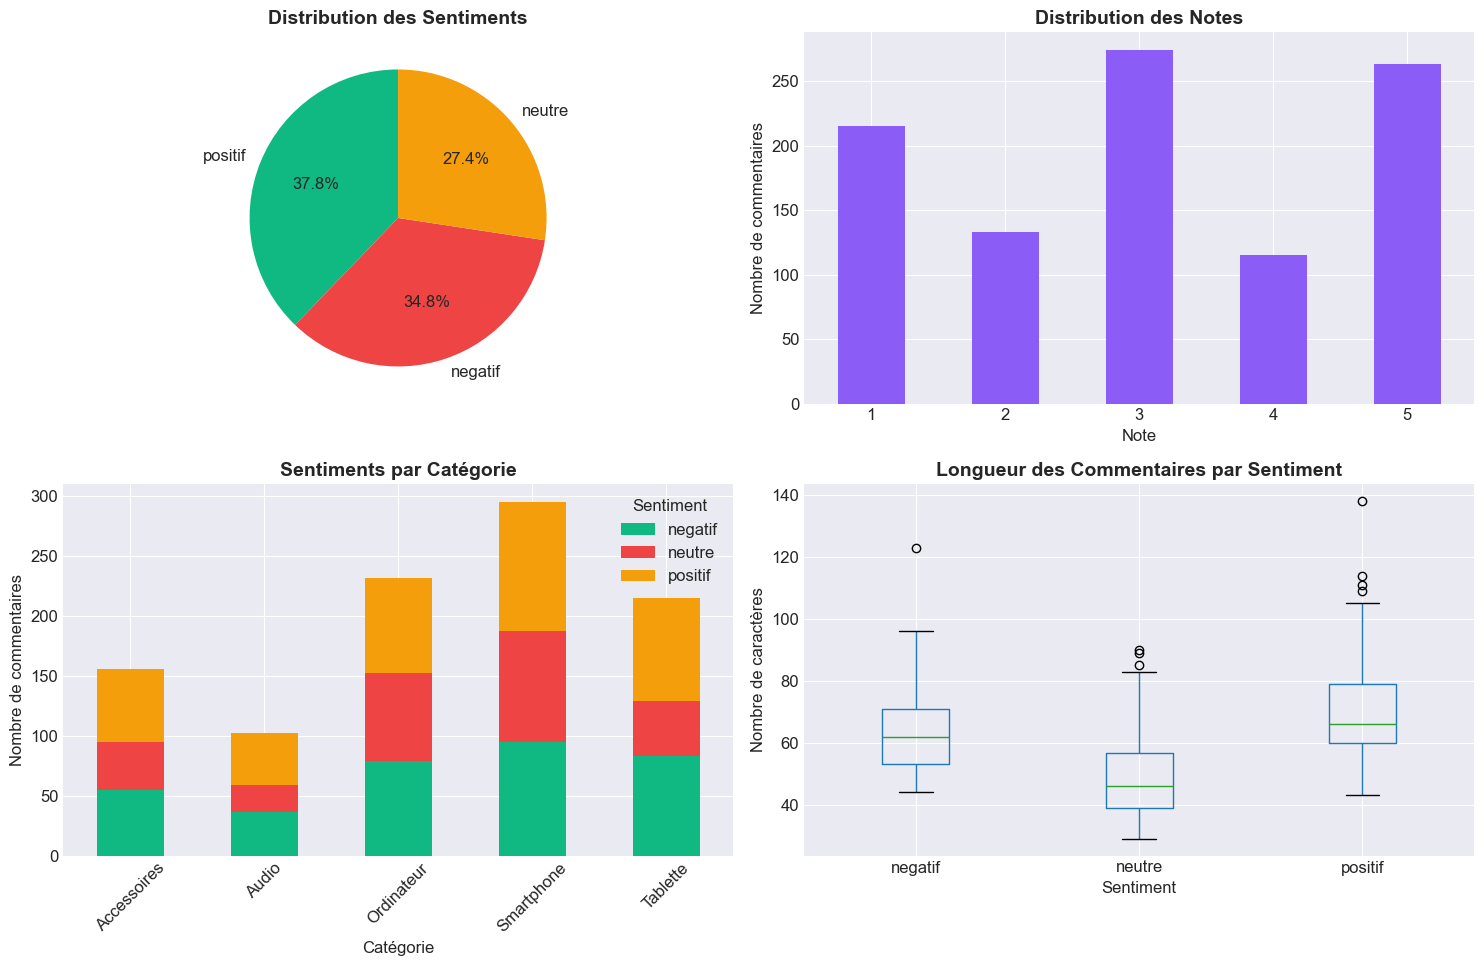


📏 STATISTIQUES SUR LA LONGUEUR DES COMMENTAIRES
           count  mean   std   min   25%   50%   75%    max
sentiment                                                  
negatif    348.0  62.5  12.5  44.0  53.0  62.0  71.0  123.0
neutre     274.0  48.9  13.3  29.0  39.0  46.0  56.8   90.0
positif    378.0  69.4  14.6  43.0  60.0  66.0  79.0  138.0


In [23]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution des sentiments
colors_sentiment = ['#10b981', '#ef4444', '#f59e0b']
df['sentiment'].value_counts().plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', 
                                    colors=colors_sentiment, startangle=90)
axes[0,0].set_title('Distribution des Sentiments', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('')

# 2. Distribution des notes
df['note'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='#8b5cf6')
axes[0,1].set_title('Distribution des Notes', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Note')
axes[0,1].set_ylabel('Nombre de commentaires')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Sentiments par catégorie
sentiment_cat = pd.crosstab(df['categorie'], df['sentiment'])
sentiment_cat.plot(kind='bar', ax=axes[1,0], stacked=True, color=colors_sentiment)
axes[1,0].set_title('Sentiments par Catégorie', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Catégorie')
axes[1,0].set_ylabel('Nombre de commentaires')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Sentiment')

# 4. Longueur des commentaires
df['longueur'] = df['commentaire'].str.len()
df.boxplot(column='longueur', by='sentiment', ax=axes[1,1])
axes[1,1].set_title('Longueur des Commentaires par Sentiment', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Nombre de caractères')
plt.suptitle('')  # Supprimer le titre automatique du boxplot

plt.tight_layout()
plt.show()

# Statistiques sur la longueur
print("\n📏 STATISTIQUES SUR LA LONGUEUR DES COMMENTAIRES")
print("=" * 50)
print(df.groupby('sentiment')['longueur'].describe().round(1))

### 2.3 Analyse de la Qualité des Données

Identifions les problèmes potentiels dans nos données.

In [24]:
# Fonction pour détecter les problèmes dans les commentaires
def analyser_problemes(df):
    """Analyse les problèmes de qualité dans les commentaires"""
    problemes = {
        'urls': 0,
        'emails': 0,
        'hashtags': 0,
        'emojis': 0,
        'espaces_multiples': 0,
        'ponctuation_excessive': 0,
        'majuscules_excessives': 0,
        'caracteres_speciaux': 0
    }
    
    for commentaire in df['commentaire']:
        # URLs
        if re.search(r'https?://\S+|www\.\S+', commentaire):
            problemes['urls'] += 1
        
        # Emails
        if re.search(r'\S+@\S+', commentaire):
            problemes['emails'] += 1
        
        # Hashtags
        if re.search(r'#\w+', commentaire):
            problemes['hashtags'] += 1
        
        # Emojis
        if re.search(r'[😀-🙏]', commentaire):
            problemes['emojis'] += 1
        
        # Espaces multiples
        if re.search(r'\s{2,}', commentaire):
            problemes['espaces_multiples'] += 1
        
        # Ponctuation excessive (plus de 2 caractères identiques)
        if re.search(r'[!?]{3,}', commentaire):
            problemes['ponctuation_excessive'] += 1
        
        # Majuscules excessives (mots entiers en majuscules)
        mots = commentaire.split()
        mots_majuscules = [m for m in mots if m.isupper() and len(m) > 2]
        if len(mots_majuscules) >= 2:
            problemes['majuscules_excessives'] += 1
        
        # Caractères spéciaux
        if re.search(r'[€$£¥]', commentaire):
            problemes['caracteres_speciaux'] += 1
    
    return problemes

# Analyser les problèmes
problemes = analyser_problemes(df)

print("🔍 ANALYSE DE LA QUALITÉ DES DONNÉES")
print("=" * 50)
print(f"Total de commentaires analysés : {len(df)}\n")

# Afficher les résultats
for probleme, count in sorted(problemes.items(), key=lambda x: x[1], reverse=True):
    pourcentage = (count / len(df)) * 100
    if count > 0:
        print(f"{'✗' if count > 50 else '⚠️'} {probleme.replace('_', ' ').title()} : "
              f"{count} ({pourcentage:.1f}%)")

# Exemples de commentaires problématiques
print("\n📝 EXEMPLES DE COMMENTAIRES PROBLÉMATIQUES")
print("=" * 50)

# Trouver des exemples
for idx, row in df.iterrows():
    commentaire = row['commentaire']
    if re.search(r'https?://\S+|www\.\S+', commentaire) and re.search(r'#\w+', commentaire):
        print(f"\nCommentaire avec URL et hashtag :")
        print(f"→ {commentaire}")
        break

for idx, row in df.iterrows():
    commentaire = row['commentaire']
    if re.search(r'[!?]{3,}', commentaire):
        print(f"\nCommentaire avec ponctuation excessive :")
        print(f"→ {commentaire}")
        break

🔍 ANALYSE DE LA QUALITÉ DES DONNÉES
Total de commentaires analysés : 1000

✗ Espaces Multiples : 298 (29.8%)
✗ Hashtags : 179 (17.9%)
✗ Caracteres Speciaux : 143 (14.3%)
✗ Urls : 101 (10.1%)
✗ Emojis : 100 (10.0%)
✗ Ponctuation Excessive : 96 (9.6%)
⚠️ Emails : 36 (3.6%)

📝 EXEMPLES DE COMMENTAIRES PROBLÉMATIQUES

Commentaire avec URL et hashtag :
→ Ça va, conforme mais rien d'exceptionnel www.techshop.fr/promo #soldes

Commentaire avec ponctuation excessive :
→ J'ADORE !!! Exactement ce que je cherchais. Merci TechShop (383€)


## 🧹 3. Pipeline de Nettoyage

### 3.1 Définition des Fonctions de Nettoyage

Créons des fonctions modulaires pour chaque étape du nettoyage.

In [25]:
class PipelineNettoyage:
    """Pipeline de nettoyage modulaire pour textes français"""
    
    def __init__(self, config=None):
        """Initialise le pipeline avec une configuration"""
        self.config = config or {
            'minuscules': True,
            'supprimer_urls': True,
            'supprimer_emails': True,
            'supprimer_hashtags': True,
            'supprimer_mentions': True,
            'supprimer_emojis': True,
            'normaliser_ponctuation': True,
            'normaliser_espaces': True,
            'garder_accents': True,
            'supprimer_nombres': False
        }
        
        # Statistiques de nettoyage
        self.stats = defaultdict(int)
    
    def nettoyer_urls(self, texte):
        """Supprime ou remplace les URLs"""
        pattern = r'https?://\S+|www\.\S+'
        matches = len(re.findall(pattern, texte))
        if matches > 0:
            self.stats['urls_supprimees'] += matches
        return re.sub(pattern, '', texte)
    
    def nettoyer_emails(self, texte):
        """Supprime ou remplace les emails"""
        pattern = r'\S+@\S+'
        matches = len(re.findall(pattern, texte))
        if matches > 0:
            self.stats['emails_supprimes'] += matches
        return re.sub(pattern, '', texte)
    
    def nettoyer_hashtags(self, texte):
        """Supprime ou remplace les hashtags"""
        pattern = r'#\w+'
        matches = len(re.findall(pattern, texte))
        if matches > 0:
            self.stats['hashtags_supprimes'] += matches
        return re.sub(pattern, '', texte)
    
    def nettoyer_mentions(self, texte):
        """Supprime ou remplace les mentions (@user)"""
        pattern = r'@\w+'
        matches = len(re.findall(pattern, texte))
        if matches > 0:
            self.stats['mentions_supprimees'] += matches
        return re.sub(pattern, '', texte)
    
    def nettoyer_emojis(self, texte):
        """Supprime les emojis"""
        # Pattern pour les emojis les plus courants
        pattern = r'[😀-🙏🌀-🗿💀-🫿]+'
        matches = len(re.findall(pattern, texte))
        if matches > 0:
            self.stats['emojis_supprimes'] += matches
        return re.sub(pattern, '', texte)
    
    def normaliser_ponctuation(self, texte):
        """Normalise la ponctuation excessive"""
        # Remplacer ponctuation répétée par une seule occurrence
        texte = re.sub(r'([!?.]){2,}', r'\1', texte)
        
        # Espaces autour de la ponctuation
        texte = re.sub(r'\s*([!?.,;:])\s*', r'\1 ', texte)
        
        self.stats['ponctuation_normalisee'] += 1
        return texte
    
    def normaliser_espaces(self, texte):
        """Normalise les espaces multiples"""
        # Remplacer espaces multiples par un seul
        texte = re.sub(r'\s+', ' ', texte)
        
        # Supprimer espaces en début et fin
        texte = texte.strip()
        
        return texte
    
    def supprimer_accents(self, texte):
        """Supprime les accents (optionnel)"""
        texte_nfd = unicodedata.normalize('NFD', texte)
        return ''.join(char for char in texte_nfd if unicodedata.category(char) != 'Mn')
    
    def supprimer_nombres(self, texte):
        """Supprime ou remplace les nombres"""
        # Garder les nombres dans certains contextes (ex: "5 étoiles")
        texte = re.sub(r'\b\d+€\b', '[PRIX]', texte)  # Remplacer prix
        texte = re.sub(r'\b\d+\s*%', '[POURCENT]', texte)  # Remplacer pourcentages
        return texte
    
    def nettoyer(self, texte):
        """Applique le pipeline complet de nettoyage"""
        if not texte or not isinstance(texte, str):
            return ""
        
        # Sauvegarder l'original pour les stats
        texte_original = texte
        
        # 1. Minuscules
        if self.config['minuscules']:
            texte = texte.lower()
        
        # 2. Éléments web
        if self.config['supprimer_urls']:
            texte = self.nettoyer_urls(texte)
        
        if self.config['supprimer_emails']:
            texte = self.nettoyer_emails(texte)
        
        if self.config['supprimer_hashtags']:
            texte = self.nettoyer_hashtags(texte)
        
        if self.config['supprimer_mentions']:
            texte = self.nettoyer_mentions(texte)
        
        # 3. Emojis
        if self.config['supprimer_emojis']:
            texte = self.nettoyer_emojis(texte)
        
        # 4. Ponctuation
        if self.config['normaliser_ponctuation']:
            texte = self.normaliser_ponctuation(texte)
        
        # 5. Nombres
        if self.config['supprimer_nombres']:
            texte = self.supprimer_nombres(texte)
        
        # 6. Accents
        if not self.config['garder_accents']:
            texte = self.supprimer_accents(texte)
        
        # 7. Espaces (toujours en dernier)
        if self.config['normaliser_espaces']:
            texte = self.normaliser_espaces(texte)
        
        # Statistiques
        self.stats['textes_nettoyes'] += 1
        self.stats['caracteres_supprimes'] += len(texte_original) - len(texte)
        
        return texte
    
    def obtenir_stats(self):
        """Retourne les statistiques de nettoyage"""
        return dict(self.stats)
    
    def reinitialiser_stats(self):
        """Réinitialise les statistiques"""
        self.stats = defaultdict(int)

# Test du pipeline
print("✅ Pipeline de nettoyage créé avec succès !")

# Exemple d'utilisation
pipeline = PipelineNettoyage()
texte_test = "SUPER produit !!! 😊 Voir sur https://bit.ly/xyz #promo Contact: info@shop.fr"
texte_nettoye = pipeline.nettoyer(texte_test)

print(f"\n🧪 Test du pipeline :")
print(f"Original : {texte_test}")
print(f"Nettoyé  : {texte_nettoye}")
print(f"\nStatistiques : {pipeline.obtenir_stats()}")

✅ Pipeline de nettoyage créé avec succès !

🧪 Test du pipeline :
Original : SUPER produit !!! 😊 Voir sur https://bit.ly/xyz #promo Contact: info@shop.fr
Nettoyé  : super produit! voir sur contact:

Statistiques : {'urls_supprimees': 1, 'emails_supprimes': 1, 'hashtags_supprimes': 1, 'emojis_supprimes': 1, 'ponctuation_normalisee': 1, 'textes_nettoyes': 1, 'caracteres_supprimes': 44}


### 3.2 Application du Nettoyage au Dataset

Appliquons notre pipeline à l'ensemble des commentaires.

In [26]:
# Créer différentes configurations pour comparer
configs = {
    'minimal': {
        'minuscules': True,
        'normaliser_espaces': True,
        'supprimer_urls': False,
        'supprimer_emails': False,
        'supprimer_hashtags': False,
        'supprimer_mentions': False,
        'supprimer_emojis': False,
        'normaliser_ponctuation': False,
        'garder_accents': True,
        'supprimer_nombres': False
    },
    'standard': {
        'minuscules': True,
        'supprimer_urls': True,
        'supprimer_emails': True,
        'supprimer_hashtags': True,
        'supprimer_mentions': True,
        'supprimer_emojis': True,
        'normaliser_ponctuation': True,
        'normaliser_espaces': True,
        'garder_accents': True,
        'supprimer_nombres': False
    },
    'agressif': {
        'minuscules': True,
        'supprimer_urls': True,
        'supprimer_emails': True,
        'supprimer_hashtags': True,
        'supprimer_mentions': True,
        'supprimer_emojis': True,
        'normaliser_ponctuation': True,
        'normaliser_espaces': True,
        'garder_accents': False,  # Supprime les accents
        'supprimer_nombres': True   # Supprime les nombres
    }
}

# Appliquer chaque configuration
resultats = {}

for nom_config, config in configs.items():
    print(f"\n🔧 Application de la configuration '{nom_config}'...")
    
    # Créer un nouveau pipeline
    pipeline = PipelineNettoyage(config)
    
    # Mesurer le temps
    start_time = time.time()
    
    # Appliquer le nettoyage
    df[f'commentaire_{nom_config}'] = df['commentaire'].apply(pipeline.nettoyer)
    
    temps_ecoule = time.time() - start_time
    
    # Sauvegarder les résultats
    resultats[nom_config] = {
        'temps': temps_ecoule,
        'stats': pipeline.obtenir_stats(),
        'exemple': df[f'commentaire_{nom_config}'].iloc[0]
    }
    
    print(f"✅ Terminé en {temps_ecoule:.2f} secondes")
    print(f"📊 Stats : {pipeline.obtenir_stats()['textes_nettoyes']} textes traités")

# Comparaison des résultats
print("\n📊 COMPARAISON DES CONFIGURATIONS")
print("=" * 80)

# Exemple de transformation
idx_exemple = 5
print(f"\nExemple de transformation (commentaire #{idx_exemple}) :")
print(f"Original : {df.iloc[idx_exemple]['commentaire']}")

for config_name in configs.keys():
    print(f"\n{config_name.capitalize()} : {df.iloc[idx_exemple][f'commentaire_{config_name}']}")


🔧 Application de la configuration 'minimal'...
✅ Terminé en 0.00 secondes
📊 Stats : 1000 textes traités

🔧 Application de la configuration 'standard'...
✅ Terminé en 0.02 secondes
📊 Stats : 1000 textes traités

🔧 Application de la configuration 'agressif'...
✅ Terminé en 0.02 secondes
📊 Stats : 1000 textes traités

📊 COMPARAISON DES CONFIGURATIONS

Exemple de transformation (commentaire #5) :
Original : Attention  FAKE  !  Ce  n'est  pas  le  produit  original

Minimal : attention fake ! ce n'est pas le produit original

Standard : attention fake! ce n'est pas le produit original

Agressif : attention fake! ce n'est pas le produit original


### 3.3 Analyse de l'Impact du Nettoyage

Mesurons l'impact de chaque configuration sur nos données.

📊 MÉTRIQUES PAR CONFIGURATION
                               minimal  standard  agressif
Longueur moyenne (caractères)    58.97     53.51     53.66
Longueur min                     29.00     29.00     29.00
Longueur max                    122.00     94.00     94.00
Nombre moyen de mots              9.22      8.42      8.42
Vocabulaire unique              291.00    278.00    277.00
Total de mots                  9223.00   8419.00   8419.00
Réduction moyenne (%)             3.61     11.56     11.27


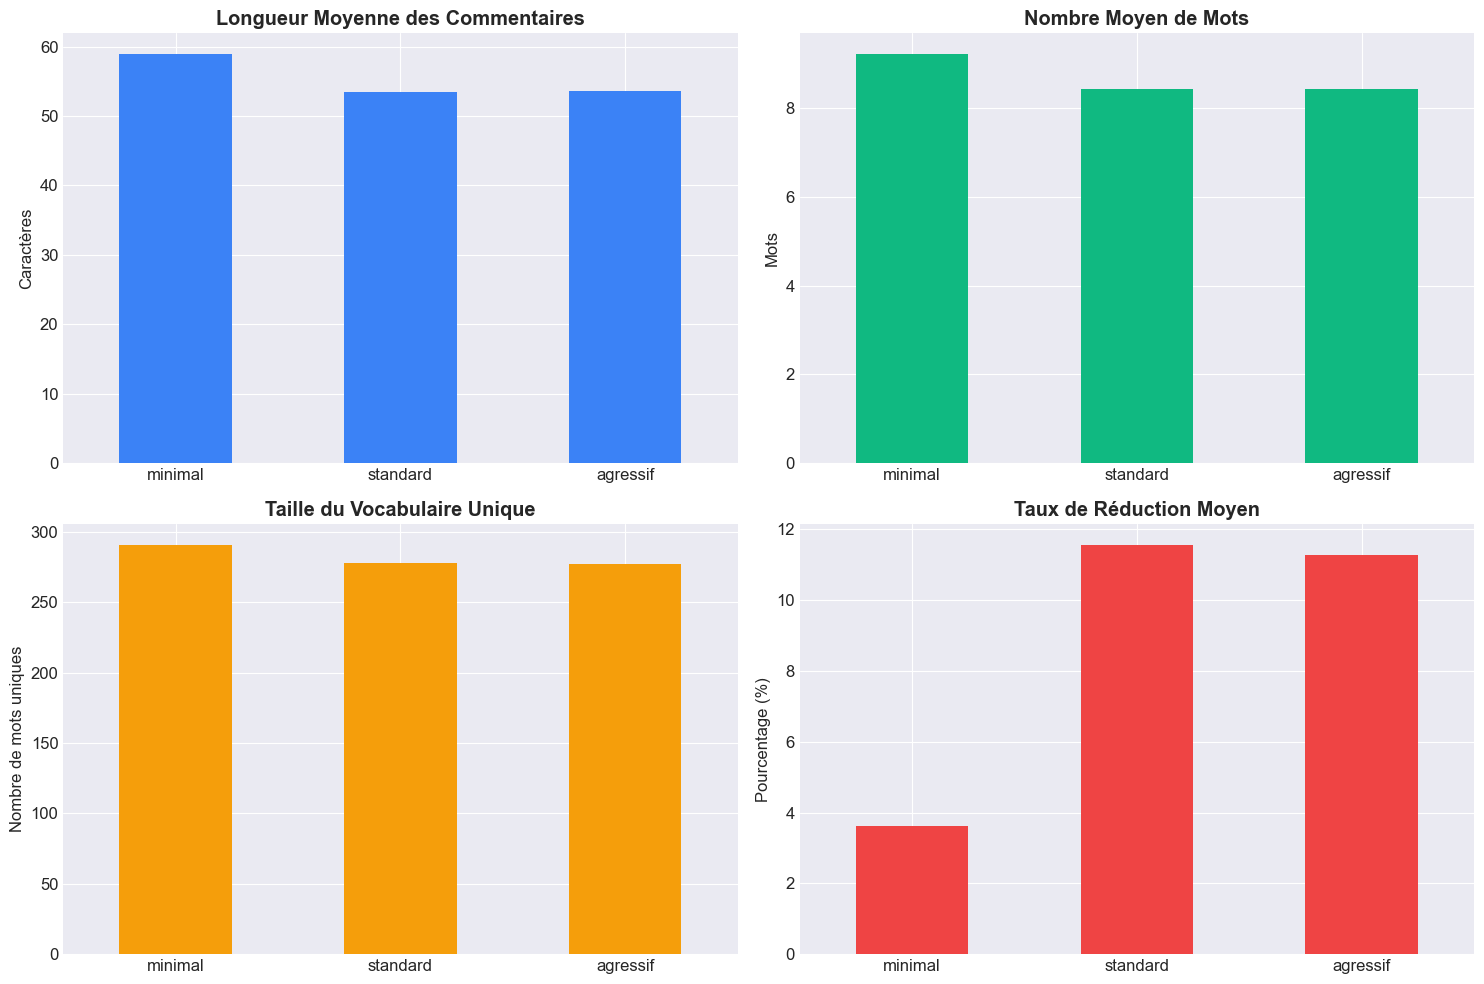

In [27]:
# Calculer les métriques pour chaque configuration
metriques = pd.DataFrame()

for config_name in configs.keys():
    col_name = f'commentaire_{config_name}'
    
    # Métriques de base
    metriques.loc['Longueur moyenne (caractères)', config_name] = df[col_name].str.len().mean()
    metriques.loc['Longueur min', config_name] = df[col_name].str.len().min()
    metriques.loc['Longueur max', config_name] = df[col_name].str.len().max()
    
    # Nombre de mots
    df[f'nb_mots_{config_name}'] = df[col_name].str.split().str.len()
    metriques.loc['Nombre moyen de mots', config_name] = df[f'nb_mots_{config_name}'].mean()
    
    # Vocabulaire unique
    tous_mots = ' '.join(df[col_name]).split()
    metriques.loc['Vocabulaire unique', config_name] = len(set(tous_mots))
    metriques.loc['Total de mots', config_name] = len(tous_mots)
    
    # Taux de réduction
    reduction = (df['commentaire'].str.len() - df[col_name].str.len()) / df['commentaire'].str.len()
    metriques.loc['Réduction moyenne (%)', config_name] = reduction.mean() * 100

# Afficher les métriques
print("📊 MÉTRIQUES PAR CONFIGURATION")
print("=" * 80)
print(metriques.round(2))

# Visualisation des métriques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Longueur moyenne
metriques.loc['Longueur moyenne (caractères)'].plot(kind='bar', ax=axes[0,0], color='#3b82f6')
axes[0,0].set_title('Longueur Moyenne des Commentaires', fontweight='bold')
axes[0,0].set_ylabel('Caractères')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Nombre de mots moyens
metriques.loc['Nombre moyen de mots'].plot(kind='bar', ax=axes[0,1], color='#10b981')
axes[0,1].set_title('Nombre Moyen de Mots', fontweight='bold')
axes[0,1].set_ylabel('Mots')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Vocabulaire unique
metriques.loc['Vocabulaire unique'].plot(kind='bar', ax=axes[1,0], color='#f59e0b')
axes[1,0].set_title('Taille du Vocabulaire Unique', fontweight='bold')
axes[1,0].set_ylabel('Nombre de mots uniques')
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Taux de réduction
metriques.loc['Réduction moyenne (%)'].plot(kind='bar', ax=axes[1,1], color='#ef4444')
axes[1,1].set_title('Taux de Réduction Moyen', fontweight='bold')
axes[1,1].set_ylabel('Pourcentage (%)')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## ✂️ 4. Tokenisation

### 4.1 Implémentation de Différentes Méthodes

In [28]:
class Tokeniseur:
    """Classe pour différentes méthodes de tokenisation"""
    
    def __init__(self):
        # Pattern pour tokenisation avancée
        self.pattern_avance = re.compile(r'''
            \w+(?:'\w+)?           # Mots avec apostrophes (l'homme, aujourd'hui)
            |[!?.,;:]+             # Ponctuation groupée
            |\S                    # Tout autre caractère non-espace
        ''', re.VERBOSE)
    
    def tokeniser_simple(self, texte):
        """Tokenisation simple avec split()"""
        return texte.split()
    
    def tokeniser_ponctuation(self, texte):
        """Tokenisation en séparant la ponctuation"""
        # Ajouter des espaces autour de la ponctuation
        for p in string.punctuation:
            texte = texte.replace(p, f' {p} ')
        # Normaliser les espaces et split
        return texte.split()
    
    def tokeniser_regex(self, texte):
        """Tokenisation avec regex avancée"""
        return self.pattern_avance.findall(texte)
    
    def tokeniser_intelligent(self, texte):
        """Tokenisation intelligente pour le français"""
        # Gérer les contractions françaises
        contractions = {
            "c'est": ["c'", "est"],
            "j'ai": ["j'", "ai"],
            "l'homme": ["l'", "homme"],
            "d'accord": ["d'", "accord"],
            "n'est": ["n'", "est"],
            "qu'il": ["qu'", "il"],
            "s'il": ["s'", "il"]
        }
        
        tokens = self.tokeniser_regex(texte)
        
        # Traiter les contractions
        tokens_finaux = []
        for token in tokens:
            token_lower = token.lower()
            if token_lower in contractions:
                tokens_finaux.extend(contractions[token_lower])
            else:
                tokens_finaux.append(token)
        
        return tokens_finaux

# Test des différentes méthodes
tokeniseur = Tokeniseur()
texte_test = "C'est génial ! J'ai adoré l'expérience... N'est-ce pas ?"

print("🔤 COMPARAISON DES MÉTHODES DE TOKENISATION")
print("=" * 60)
print(f"Texte original : {texte_test}\n")

methodes = [
    ('Simple (split)', tokeniseur.tokeniser_simple),
    ('Avec ponctuation', tokeniseur.tokeniser_ponctuation),
    ('Regex avancée', tokeniseur.tokeniser_regex),
    ('Intelligente', tokeniseur.tokeniser_intelligent)
]

for nom, methode in methodes:
    tokens = methode(texte_test)
    print(f"\n{nom} ({len(tokens)} tokens) :")
    print(f"→ {tokens}")

🔤 COMPARAISON DES MÉTHODES DE TOKENISATION
Texte original : C'est génial ! J'ai adoré l'expérience... N'est-ce pas ?


Simple (split) (9 tokens) :
→ ["C'est", 'génial', '!', "J'ai", 'adoré', "l'expérience...", "N'est-ce", 'pas', '?']

Avec ponctuation (22 tokens) :
→ ['C', "'", 'est', 'génial', '!', 'J', "'", 'ai', 'adoré', 'l', "'", 'expérience', '.', '.', '.', 'N', "'", 'est', '-', 'ce', 'pas', '?']

Regex avancée (12 tokens) :
→ ["C'est", 'génial', '!', "J'ai", 'adoré', "l'expérience", '...', "N'est", '-', 'ce', 'pas', '?']

Intelligente (15 tokens) :
→ ["c'", 'est', 'génial', '!', "j'", 'ai', 'adoré', "l'expérience", '...', "n'", 'est', '-', 'ce', 'pas', '?']


### 4.2 Application de la Tokenisation au Dataset

In [29]:
# Appliquer la tokenisation sur les commentaires nettoyés
print("🔄 Application de la tokenisation...\n")

# Utiliser la configuration 'standard' comme base
col_source = 'commentaire_standard'

# Tokeniser tous les commentaires
df['tokens'] = df[col_source].apply(tokeniseur.tokeniser_intelligent)
df['nb_tokens'] = df['tokens'].apply(len)

# Statistiques
print("📊 STATISTIQUES DE TOKENISATION")
print("=" * 50)
print(f"Nombre moyen de tokens : {df['nb_tokens'].mean():.1f}")
print(f"Min tokens : {df['nb_tokens'].min()}")
print(f"Max tokens : {df['nb_tokens'].max()}")
print(f"\nDistribution par sentiment :")
print(df.groupby('sentiment')['nb_tokens'].describe()[['mean', 'std', 'min', 'max']].round(1))

# Vocabulaire
tous_tokens = [token for tokens in df['tokens'] for token in tokens]
vocabulaire = Counter(tous_tokens)

print(f"\n📚 VOCABULAIRE")
print("=" * 50)
print(f"Taille du vocabulaire : {len(vocabulaire)} mots uniques")
print(f"Total de tokens : {len(tous_tokens)}")
print(f"\nTop 20 des mots les plus fréquents :")
for mot, freq in vocabulaire.most_common(20):
    print(f"  '{mot}' : {freq} ({freq/len(tous_tokens)*100:.1f}%)")

🔄 Application de la tokenisation...

📊 STATISTIQUES DE TOKENISATION
Nombre moyen de tokens : 10.4
Min tokens : 4
Max tokens : 23

Distribution par sentiment :
           mean  std  min   max
sentiment                      
negatif    10.1  2.0  7.0  17.0
neutre      8.9  2.9  4.0  17.0
positif    11.8  3.6  7.0  23.0

📚 VOCABULAIRE
Taille du vocabulaire : 276 mots uniques
Total de tokens : 10430

Top 20 des mots les plus fréquents :
  '.' : 688 (6.6%)
  'produit' : 440 (4.2%)
  '!' : 331 (3.2%)
  'à' : 305 (2.9%)
  ',' : 271 (2.6%)
  'prix' : 238 (2.3%)
  'le' : 221 (2.1%)
  'pas' : 212 (2.0%)
  'et' : 188 (1.8%)
  'ce' : 183 (1.8%)
  'qualité' : 177 (1.7%)
  'la' : 174 (1.7%)
  'mais' : 157 (1.5%)
  '(' : 143 (1.4%)
  '€' : 143 (1.4%)
  ')' : 143 (1.4%)
  'livraison' : 134 (1.3%)
  'très' : 131 (1.3%)
  'je' : 130 (1.2%)
  'de' : 127 (1.2%)


## 🛑 5. Gestion des Stopwords

### 5.1 Création d'une Liste de Stopwords Personnalisée

In [30]:
# Stopwords français de base
stopwords_francais = {
    # Articles
    'le', 'la', 'les', 'un', 'une', 'des',
    # Pronoms
    'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles',
    'me', 'te', 'se', 'ce', 'cet', 'cette', 'ces',
    # Prépositions
    'de', 'du', 'des', 'à', 'au', 'aux', 'par', 'pour', 'avec', 'sans',
    'sur', 'sous', 'dans', 'en', 'entre', 'vers', 'chez',
    # Conjonctions
    'et', 'ou', 'mais', 'donc', 'car', 'ni', 'que', 'qui',
    # Adverbes courants
    'ne', 'pas', 'plus', 'très', 'bien', 'aussi', 'tout', 'tous',
    # Verbes auxiliaires
    'être', 'avoir', 'ai', 'as', 'a', 'avons', 'avez', 'ont',
    'suis', 'es', 'est', 'sommes', 'êtes', 'sont',
    # Autres mots courants
    'y', 'on', 'ça', 'été', 'faire', 'fait', 'peu', 'si'
}

# Stopwords spécifiques au domaine e-commerce
stopwords_ecommerce = {
    'produit', 'article', 'commande', 'achat', 'site',
    'livraison', 'prix', 'qualité', 'service', 'client'
}

# Analyser les mots les plus fréquents pour identifier d'autres stopwords potentiels
print("🔍 ANALYSE DES CANDIDATS STOPWORDS")
print("=" * 50)
print("\nMots très fréquents (candidats stopwords) :")

mots_frequents = []
for mot, freq in vocabulaire.most_common(50):
    if freq > len(df) * 0.05:  # Présent dans plus de 5% des documents
        if mot.lower() not in stopwords_francais and len(mot) > 1:
            mots_frequents.append(mot)
            print(f"  '{mot}' : {freq} occurrences ({freq/len(df)*100:.1f}% des documents)")

# Décision : quels mots garder comme stopwords ?
print("\n💡 Recommandation : Ajouter ces mots aux stopwords ?")
print("(Dans un contexte d'analyse de sentiment, certains mots comme 'super', 'bien' sont importants)")

🔍 ANALYSE DES CANDIDATS STOPWORDS

Mots très fréquents (candidats stopwords) :
  'produit' : 440 occurrences (44.0% des documents)
  'prix' : 238 occurrences (23.8% des documents)
  'qualité' : 177 occurrences (17.7% des documents)
  'livraison' : 134 occurrences (13.4% des documents)
  'description' : 107 occurrences (10.7% des documents)
  'correct' : 102 occurrences (10.2% des documents)
  'conforme' : 95 occurrences (9.5% des documents)
  'mieux' : 89 occurrences (8.9% des documents)
  'nickel' : 80 occurrences (8.0% des documents)
  'satisfait' : 79 occurrences (7.9% des documents)
  'parfaitement' : 78 occurrences (7.8% des documents)
  'fonctionne' : 76 occurrences (7.6% des documents)
  'élevé' : 72 occurrences (7.2% des documents)
  'j'' : 67 occurrences (6.7% des documents)
  'mon' : 65 occurrences (6.5% des documents)
  'achat' : 65 occurrences (6.5% des documents)
  'correspond' : 64 occurrences (6.4% des documents)
  'bof' : 64 occurrences (6.4% des documents)
  'ok' : 56 

### 5.2 Application et Impact des Stopwords

In [31]:
# Fonction pour supprimer les stopwords
def supprimer_stopwords(tokens, stopwords):
    """Supprime les stopwords d'une liste de tokens"""
    return [token for token in tokens if token.lower() not in stopwords]

# Tester différentes configurations de stopwords
configs_stopwords = {
    'sans_stopwords': set(),
    'stopwords_base': stopwords_francais,
    'stopwords_complet': stopwords_francais.union(stopwords_ecommerce)
}

# Appliquer chaque configuration
for nom, stopwords in configs_stopwords.items():
    df[f'tokens_{nom}'] = df['tokens'].apply(lambda t: supprimer_stopwords(t, stopwords))
    df[f'nb_tokens_{nom}'] = df[f'tokens_{nom}'].apply(len)

# Comparaison de l'impact
print("📊 IMPACT DE LA SUPPRESSION DES STOPWORDS")
print("=" * 60)

comparaison = pd.DataFrame()
for nom in configs_stopwords.keys():
    comparaison.loc['Tokens moyens', nom] = df[f'nb_tokens_{nom}'].mean()
    comparaison.loc['Réduction (%)', nom] = (1 - df[f'nb_tokens_{nom}'].mean() / df['nb_tokens'].mean()) * 100
    
    # Taille du vocabulaire
    tous_tokens_config = [token for tokens in df[f'tokens_{nom}'] for token in tokens]
    comparaison.loc['Taille vocabulaire', nom] = len(set(tous_tokens_config))

print(comparaison.round(1))

# Exemple visuel
print("\n📝 EXEMPLE DE TRANSFORMATION")
print("=" * 60)
idx = 10
print(f"Commentaire original : {df.iloc[idx]['commentaire']}")
print(f"\nTokens originaux ({len(df.iloc[idx]['tokens'])}) :")
print(f"→ {df.iloc[idx]['tokens']}")
print(f"\nSans stopwords de base ({len(df.iloc[idx]['tokens_stopwords_base'])}) :")
print(f"→ {df.iloc[idx]['tokens_stopwords_base']}")
print(f"\nSans tous les stopwords ({len(df.iloc[idx]['tokens_stopwords_complet'])}) :")
print(f"→ {df.iloc[idx]['tokens_stopwords_complet']}")

📊 IMPACT DE LA SUPPRESSION DES STOPWORDS
                    sans_stopwords  stopwords_base  stopwords_complet
Tokens moyens                 10.4             7.5                6.3
Réduction (%)                  0.0            28.3               39.6
Taille vocabulaire           276.0           247.0              239.0

📝 EXEMPLE DE TRANSFORMATION
Commentaire original : Nickel ! Conforme à la description et arrivé rapidement

Tokens originaux (9) :
→ ['nickel', '!', 'conforme', 'à', 'la', 'description', 'et', 'arrivé', 'rapidement']

Sans stopwords de base (6) :
→ ['nickel', '!', 'conforme', 'description', 'arrivé', 'rapidement']

Sans tous les stopwords (6) :
→ ['nickel', '!', 'conforme', 'description', 'arrivé', 'rapidement']


## 🌱 6. Lemmatisation et Stemming

### 6.1 Implémentation Simple

In [32]:
class StemmerFrancais:
    """Stemmer simple pour le français"""
    
    def __init__(self):
        # Suffixes français courants (ordre important)
        self.suffixes = [
            'issement', 'ellement', 'ation', 'ateur', 'atrice',
            'ement', 'ment', 'iste', 'isme', 'able', 'ible',
            'eur', 'euse', 'eux', 'euses', 'ité', 'if', 'ive',
            'aux', 'al', 'ale', 'ant', 'ante', 'ants', 'antes',
            'é', 'ée', 'és', 'ées', 'er', 'ez', 'ons', 'ais',
            'ait', 'aient', 's'
        ]
    
    def stem(self, mot):
        """Applique le stemming à un mot"""
        if len(mot) <= 3:
            return mot
        
        # Chercher et supprimer le suffixe le plus long
        for suffixe in self.suffixes:
            if mot.endswith(suffixe) and len(mot) - len(suffixe) >= 3:
                return mot[:-len(suffixe)]
        
        return mot

# Dictionnaire simple de lemmatisation
lemmes_francais = {
    # Verbes
    'suis': 'être', 'es': 'être', 'est': 'être', 'sommes': 'être', 'êtes': 'être', 'sont': 'être',
    'ai': 'avoir', 'as': 'avoir', 'a': 'avoir', 'avons': 'avoir', 'avez': 'avoir', 'ont': 'avoir',
    'achète': 'acheter', 'acheté': 'acheter', 'acheter': 'acheter', 'achetez': 'acheter',
    'recommande': 'recommander', 'recommandé': 'recommander', 'recommander': 'recommander',
    'adore': 'adorer', 'adoré': 'adorer', 'adorer': 'adorer', 'adorez': 'adorer',
    # Noms
    'produits': 'produit', 'livraisons': 'livraison', 'commandes': 'commande',
    'qualités': 'qualité', 'services': 'service', 'clients': 'client',
    # Adjectifs
    'super': 'super', 'génial': 'génial', 'géniaux': 'génial',
    'excellent': 'excellent', 'excellente': 'excellent', 'excellents': 'excellent',
    'bon': 'bon', 'bonne': 'bon', 'bons': 'bon', 'bonnes': 'bon',
    'mauvais': 'mauvais', 'mauvaise': 'mauvais', 'mauvaises': 'mauvais'
}

def lemmatiser_simple(mot, dictionnaire):
    """Lemmatisation basique avec dictionnaire"""
    return dictionnaire.get(mot.lower(), mot.lower())

# Test
stemmer = StemmerFrancais()
mots_test = ['recommandation', 'livraisons', 'excellente', 'rapidement', 'satisfaisant']

print("🌱 TEST DE STEMMING ET LEMMATISATION")
print("=" * 50)
print(f"{'Mot':<15} {'Stem':<15} {'Lemme':<15}")
print("-" * 45)

for mot in mots_test:
    stem = stemmer.stem(mot)
    lemme = lemmatiser_simple(mot, lemmes_francais)
    print(f"{mot:<15} {stem:<15} {lemme:<15}")

🌱 TEST DE STEMMING ET LEMMATISATION
Mot             Stem            Lemme          
---------------------------------------------
recommandation  recommand       recommandation 
livraisons      livrais         livraison      
excellente      excellente      excellent      
rapidement      rapid           rapidement     
satisfaisant    satisfais       satisfaisant   


### 6.2 Application au Dataset

In [33]:
# Appliquer stemming et lemmatisation
print("🔄 Application du stemming et de la lemmatisation...\n")

# Utiliser les tokens sans stopwords de base
tokens_source = 'tokens_stopwords_base'

# Stemming
df['tokens_stem'] = df[tokens_source].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens]
)

# Lemmatisation
df['tokens_lemma'] = df[tokens_source].apply(
    lambda tokens: [lemmatiser_simple(token, lemmes_francais) for token in tokens]
)

# Comparaison du vocabulaire
vocab_original = set([token for tokens in df[tokens_source] for token in tokens])
vocab_stem = set([token for tokens in df['tokens_stem'] for token in tokens])
vocab_lemma = set([token for tokens in df['tokens_lemma'] for token in tokens])

print("📊 IMPACT SUR LE VOCABULAIRE")
print("=" * 50)
print(f"Vocabulaire original : {len(vocab_original)} mots")
print(f"Après stemming : {len(vocab_stem)} mots ({(1-len(vocab_stem)/len(vocab_original))*100:.1f}% de réduction)")
print(f"Après lemmatisation : {len(vocab_lemma)} mots ({(1-len(vocab_lemma)/len(vocab_original))*100:.1f}% de réduction)")

# Exemple de transformation
print("\n📝 EXEMPLE DE TRANSFORMATION")
print("=" * 50)
idx = 15
print(f"Tokens originaux : {df.iloc[idx][tokens_source][:10]}...")
print(f"Après stemming : {df.iloc[idx]['tokens_stem'][:10]}...")
print(f"Après lemmatisation : {df.iloc[idx]['tokens_lemma'][:10]}...")

🔄 Application du stemming et de la lemmatisation...

📊 IMPACT SUR LE VOCABULAIRE
Vocabulaire original : 247 mots
Après stemming : 245 mots (0.8% de réduction)
Après lemmatisation : 246 mots (0.4% de réduction)

📝 EXEMPLE DE TRANSFORMATION
Tokens originaux : ['bof', 'bof', '.', 'qualité', 'moyenne', 'prix', 'trop', 'élevé']...
Après stemming : ['bof', 'bof', '.', 'qual', 'moyenne', 'prix', 'trop', 'élev']...
Après lemmatisation : ['bof', 'bof', '.', 'qualité', 'moyenne', 'prix', 'trop', 'élevé']...


## 📊 7. Pipeline Complet et Analyse de Sentiment

### 7.1 Assemblage du Pipeline Final

In [34]:
class PipelineComplet:
    """Pipeline complet de preprocessing pour l'analyse de sentiment"""
    
    def __init__(self, config=None):
        self.config = config or {
            'nettoyage': 'standard',
            'tokenisation': 'intelligent',
            'stopwords': True,
            'normalisation': 'lemmatisation'  # 'none', 'stemming', 'lemmatisation'
        }
        
        # Initialiser les composants
        self.nettoyeur = PipelineNettoyage(configs['standard'])
        self.tokeniseur = Tokeniseur()
        self.stemmer = StemmerFrancais()
        self.stopwords = stopwords_francais
        self.lemmes = lemmes_francais
    
    def preprocess(self, texte):
        """Applique le pipeline complet de preprocessing"""
        # 1. Nettoyage
        texte_propre = self.nettoyeur.nettoyer(texte)
        
        # 2. Tokenisation
        if self.config['tokenisation'] == 'intelligent':
            tokens = self.tokeniseur.tokeniser_intelligent(texte_propre)
        else:
            tokens = self.tokeniseur.tokeniser_simple(texte_propre)
        
        # 3. Suppression des stopwords
        if self.config['stopwords']:
            tokens = supprimer_stopwords(tokens, self.stopwords)
        
        # 4. Normalisation
        if self.config['normalisation'] == 'stemming':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.config['normalisation'] == 'lemmatisation':
            tokens = [lemmatiser_simple(token, self.lemmes) for token in tokens]
        
        return tokens
    
    def preprocess_to_text(self, texte):
        """Retourne le texte preprocessé sous forme de string"""
        tokens = self.preprocess(texte)
        return ' '.join(tokens)

# Créer le pipeline final
pipeline_final = PipelineComplet()

# Test sur quelques exemples
print("🚀 TEST DU PIPELINE COMPLET")
print("=" * 60)

exemples_test = [
    "SUPER produit !!! Je le recommande vivement 😊 #satisfait",
    "Très déçu... La livraison était en retard et le produit est cassé",
    "Correct mais sans plus. Le prix est un peu élevé pour la qualité"
]

for i, exemple in enumerate(exemples_test, 1):
    print(f"\nExemple {i} :")
    print(f"Original : {exemple}")
    tokens = pipeline_final.preprocess(exemple)
    print(f"Après preprocessing : {' '.join(tokens)}")
    print(f"Nombre de tokens : {len(tokens)}")

🚀 TEST DU PIPELINE COMPLET

Exemple 1 :
Original : SUPER produit !!! Je le recommande vivement 😊 #satisfait
Après preprocessing : super produit ! recommander vivement
Nombre de tokens : 5

Exemple 2 :
Original : Très déçu... La livraison était en retard et le produit est cassé
Après preprocessing : déçu . livraison était retard produit cassé
Nombre de tokens : 7

Exemple 3 :
Original : Correct mais sans plus. Le prix est un peu élevé pour la qualité
Après preprocessing : correct . prix élevé qualité
Nombre de tokens : 5


### 7.2 Analyse de Sentiment Simple

In [35]:
# Créer un lexique de sentiment simple
lexique_sentiment = {
    # Mots positifs
    'super': 2, 'excellent': 2, 'génial': 2, 'parfait': 2, 'top': 2,
    'bien': 1, 'bon': 1, 'satisfait': 1, 'content': 1, 'recommande': 1,
    'rapide': 1, 'conforme': 1, 'nickel': 1, 'adorer': 2, 'aimer': 1,
    
    # Mots négatifs
    'nul': -2, 'arnaque': -2, 'horrible': -2, 'catastrophe': -2,
    'déçu': -1, 'décevant': -1, 'mauvais': -1, 'problème': -1, 'cassé': -1,
    'retard': -1, 'défectueux': -1, 'fake': -2, 'cher': -1, 'lent': -1
}

def analyser_sentiment_simple(tokens, lexique):
    """Analyse de sentiment basée sur un lexique"""
    score = 0
    mots_sentiment = []
    
    for token in tokens:
        if token.lower() in lexique:
            score += lexique[token.lower()]
            mots_sentiment.append((token, lexique[token.lower()]))
    
    # Normaliser le score
    if len(tokens) > 0:
        score_normalise = score / len(tokens)
    else:
        score_normalise = 0
    
    # Déterminer le sentiment
    if score_normalise > 0.1:
        sentiment = 'positif'
    elif score_normalise < -0.1:
        sentiment = 'negatif'
    else:
        sentiment = 'neutre'
    
    return {
        'sentiment': sentiment,
        'score': score,
        'score_normalise': score_normalise,
        'mots_sentiment': mots_sentiment
    }

# Appliquer l'analyse de sentiment
print("🎭 APPLICATION DE L'ANALYSE DE SENTIMENT")
print("=" * 60)

# Preprocesser tous les commentaires
df['tokens_final'] = df['commentaire'].apply(pipeline_final.preprocess)

# Analyser le sentiment
df['analyse_sentiment'] = df['tokens_final'].apply(lambda t: analyser_sentiment_simple(t, lexique_sentiment))
df['sentiment_predit'] = df['analyse_sentiment'].apply(lambda x: x['sentiment'])
df['score_sentiment'] = df['analyse_sentiment'].apply(lambda x: x['score_normalise'])

# Exemples d'analyse
print("\n📝 EXEMPLES D'ANALYSE")
for i in range(3):
    row = df.iloc[i]
    print(f"\nCommentaire : {row['commentaire'][:80]}...")
    print(f"Sentiment réel : {row['sentiment']}")
    print(f"Sentiment prédit : {row['sentiment_predit']}")
    print(f"Score : {row['score_sentiment']:.3f}")
    
    # Mots qui ont contribué au score
    mots = row['analyse_sentiment']['mots_sentiment']
    if mots:
        print(f"Mots clés : {', '.join([f'{m[0]}({m[1]:+d})' for m in mots[:5]])}")

🎭 APPLICATION DE L'ANALYSE DE SENTIMENT

📝 EXEMPLES D'ANALYSE

Commentaire : 5  étoiles  !  Installation  facile  et  fonctionne  parfaitement...
Sentiment réel : positif
Sentiment prédit : neutre
Score : 0.000

Commentaire : 5 étoiles ! Installation facile et fonctionne parfaitement...
Sentiment réel : positif
Sentiment prédit : neutre
Score : 0.000

Commentaire : Décevant... J'attendais mieux pour ce prix 😤 http://example.com...
Sentiment réel : negatif
Sentiment prédit : negatif
Score : -0.200
Mots clés : décevant(-1)


## 📈 8. Évaluation et Visualisation

### 8.1 Métriques de Performance

📊 PERFORMANCE DE L'ANALYSE DE SENTIMENT

Accuracy globale : 72.10%

Classification Report :
              precision    recall  f1-score   support

     negatif       1.00      0.81      0.90       348
      neutre       0.49      0.71      0.58       274
     positif       0.75      0.65      0.70       378

    accuracy                           0.72      1000
   macro avg       0.75      0.72      0.72      1000
weighted avg       0.77      0.72      0.73      1000



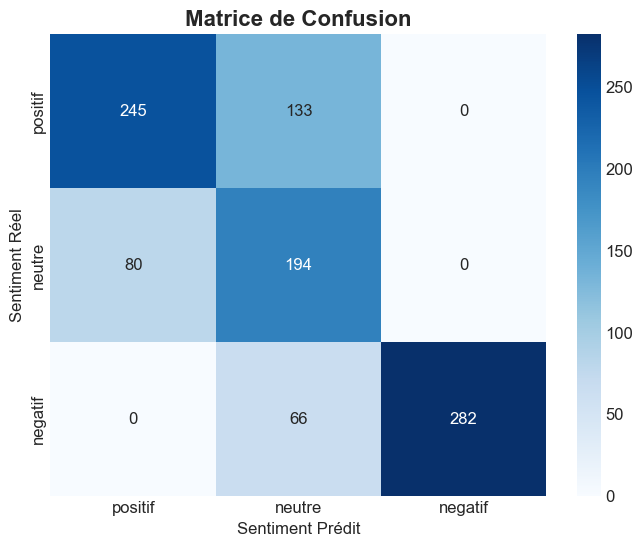


❌ ANALYSE DES ERREURS
Nombre total d'erreurs : 279 (27.9%)

Distribution des erreurs :
sentiment_predit  neutre  positif
sentiment                        
negatif               66        0
neutre                 0       80
positif              133        0


In [36]:
# Calculer les métriques
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy globale
accuracy = accuracy_score(df['sentiment'], df['sentiment_predit'])

print("📊 PERFORMANCE DE L'ANALYSE DE SENTIMENT")
print("=" * 60)
print(f"\nAccuracy globale : {accuracy:.2%}\n")

# Rapport détaillé
print("Classification Report :")
print(classification_report(df['sentiment'], df['sentiment_predit']))

# Matrice de confusion
cm = confusion_matrix(df['sentiment'], df['sentiment_predit'], 
                     labels=['positif', 'neutre', 'negatif'])

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['positif', 'neutre', 'negatif'],
            yticklabels=['positif', 'neutre', 'negatif'])
plt.title('Matrice de Confusion', fontsize=16, fontweight='bold')
plt.ylabel('Sentiment Réel')
plt.xlabel('Sentiment Prédit')
plt.show()

# Analyse des erreurs
erreurs = df[df['sentiment'] != df['sentiment_predit']]
print(f"\n❌ ANALYSE DES ERREURS")
print(f"Nombre total d'erreurs : {len(erreurs)} ({len(erreurs)/len(df)*100:.1f}%)")
print(f"\nDistribution des erreurs :")
print(pd.crosstab(erreurs['sentiment'], erreurs['sentiment_predit']))

### 8.2 Visualisations Avancées

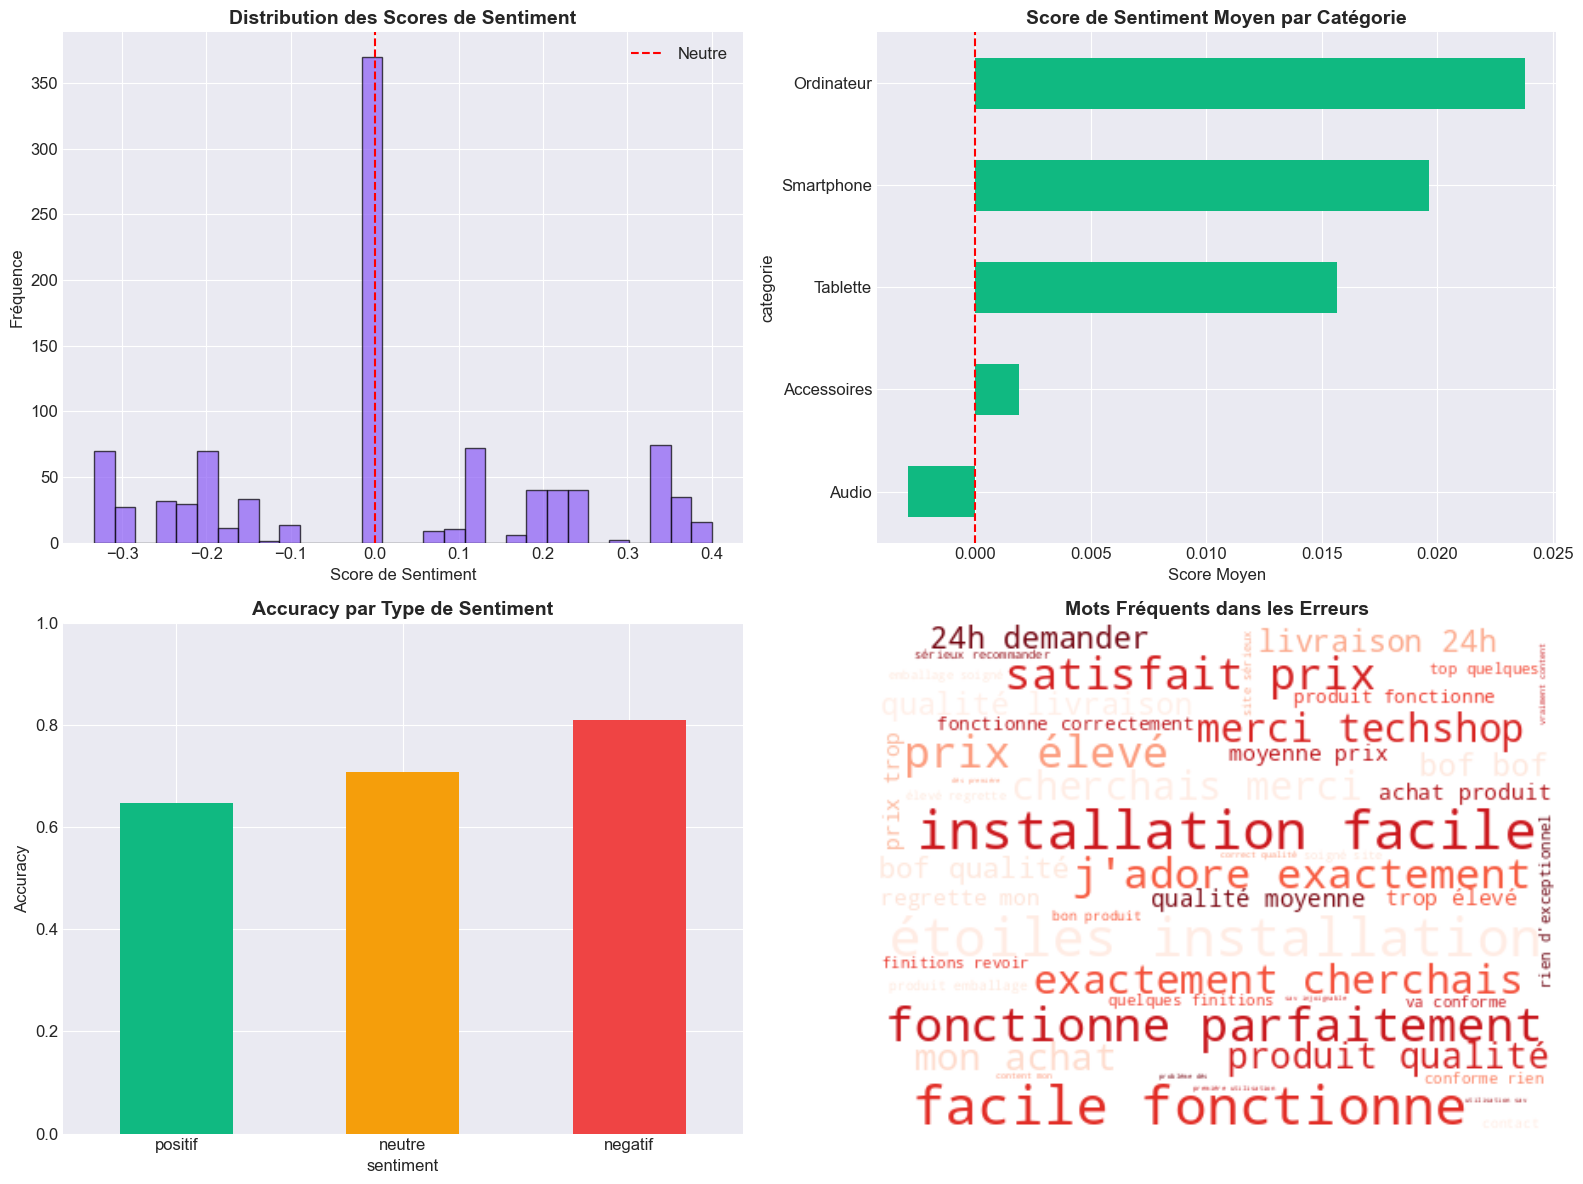

In [37]:
# Créer des visualisations informatives
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution des scores de sentiment
df['score_sentiment'].hist(bins=30, ax=axes[0,0], color='#8b5cf6', alpha=0.7, edgecolor='black')
axes[0,0].axvline(x=0, color='red', linestyle='--', label='Neutre')
axes[0,0].set_title('Distribution des Scores de Sentiment', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Score de Sentiment')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].legend()

# 2. Scores moyens par catégorie
scores_cat = df.groupby('categorie')['score_sentiment'].mean().sort_values()
scores_cat.plot(kind='barh', ax=axes[0,1], color='#10b981')
axes[0,1].set_title('Score de Sentiment Moyen par Catégorie', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Score Moyen')
axes[0,1].axvline(x=0, color='red', linestyle='--')

# 3. Performance par sentiment
performance = []
for sentiment in ['positif', 'neutre', 'negatif']:
    mask = df['sentiment'] == sentiment
    if mask.sum() > 0:
        acc = (df[mask]['sentiment'] == df[mask]['sentiment_predit']).mean()
        performance.append({'sentiment': sentiment, 'accuracy': acc})

perf_df = pd.DataFrame(performance)
perf_df.plot(x='sentiment', y='accuracy', kind='bar', ax=axes[1,0], 
            color=['#10b981', '#f59e0b', '#ef4444'], legend=False)
axes[1,0].set_title('Accuracy par Type de Sentiment', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Nuage de mots des erreurs
if len(erreurs) > 0:
    texte_erreurs = ' '.join([' '.join(tokens) for tokens in erreurs['tokens_final']])
    if texte_erreurs.strip():
        wordcloud = WordCloud(width=400, height=300, background_color='white', 
                            colormap='Reds').generate(texte_erreurs)
        axes[1,1].imshow(wordcloud, interpolation='bilinear')
        axes[1,1].axis('off')
        axes[1,1].set_title('Mots Fréquents dans les Erreurs', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 🚀 9. Optimisation et Recommandations

### 9.1 Analyse des Performances du Pipeline

In [38]:
# Benchmark des différentes étapes
import time

texte_benchmark = df['commentaire'].iloc[:100].tolist()  # 100 premiers commentaires

print("⏱️ BENCHMARK DU PIPELINE")
print("=" * 60)

# Mesurer chaque étape
etapes = [
    ('Nettoyage', lambda t: pipeline_final.nettoyeur.nettoyer(t)),
    ('Tokenisation', lambda t: pipeline_final.tokeniseur.tokeniser_intelligent(t)),
    ('Pipeline complet', lambda t: pipeline_final.preprocess(t))
]

resultats_benchmark = {}

for nom_etape, fonction in etapes:
    start = time.time()
    for texte in texte_benchmark:
        _ = fonction(texte)
    temps_total = time.time() - start
    
    resultats_benchmark[nom_etape] = {
        'temps_total': temps_total,
        'temps_par_doc': temps_total / len(texte_benchmark) * 1000,  # en ms
        'docs_par_sec': len(texte_benchmark) / temps_total
    }
    
    print(f"\n{nom_etape} :")
    print(f"  Temps total : {temps_total:.3f}s")
    print(f"  Temps par document : {resultats_benchmark[nom_etape]['temps_par_doc']:.2f}ms")
    print(f"  Documents/seconde : {resultats_benchmark[nom_etape]['docs_par_sec']:.0f}")

# Estimation pour le dataset complet
temps_estime = len(df) / resultats_benchmark['Pipeline complet']['docs_par_sec']
print(f"\n📊 Pour {len(df)} documents : ~{temps_estime:.1f} secondes")

⏱️ BENCHMARK DU PIPELINE

Nettoyage :
  Temps total : 0.003s
  Temps par document : 0.03ms
  Documents/seconde : 37452

Tokenisation :
  Temps total : 0.001s
  Temps par document : 0.01ms
  Documents/seconde : 144333

Pipeline complet :
  Temps total : 0.003s
  Temps par document : 0.03ms
  Documents/seconde : 31133

📊 Pour 1000 documents : ~0.0 secondes


### 9.2 Recommandations Finales

In [39]:
# Générer un rapport de recommandations
print("📋 RAPPORT DE RECOMMANDATIONS")
print("=" * 80)

# 1. Qualité du preprocessing
print("\n🔧 1. QUALITÉ DU PREPROCESSING")
print("-" * 40)

# Taux de réduction
reduction_moyenne = (df['commentaire'].str.len() - df['commentaire_standard'].str.len()).mean()
taux_reduction = reduction_moyenne / df['commentaire'].str.len().mean() * 100

print(f"• Réduction moyenne du texte : {taux_reduction:.1f}%")
if taux_reduction > 30:
    print("  ⚠️ Attention : réduction importante, vérifier qu'on ne perd pas d'information cruciale")
else:
    print("  ✅ Réduction raisonnable, bon équilibre")

# Vocabulaire
print(f"\n• Taille du vocabulaire final : {len(set([t for tokens in df['tokens_final'] for t in tokens]))} mots")
print("  💡 Conseil : Un vocabulaire trop grand peut nécessiter plus de données d'entraînement")

# 2. Performance de l'analyse
print("\n\n🎯 2. PERFORMANCE DE L'ANALYSE DE SENTIMENT")
print("-" * 40)

print(f"• Accuracy globale : {accuracy:.2%}")
if accuracy < 0.6:
    print("  ❌ Performance faible : enrichir le lexique ou utiliser un modèle plus sophistiqué")
elif accuracy < 0.8:
    print("  ⚠️ Performance correcte : peut être améliorée avec plus de données ou features")
else:
    print("  ✅ Bonne performance pour une approche basée sur lexique")

# 3. Optimisations suggérées
print("\n\n🚀 3. OPTIMISATIONS SUGGÉRÉES")
print("-" * 40)

suggestions = [
    "• Enrichir le lexique de sentiment avec plus de mots du domaine",
    "• Ajouter la gestion des négations ('pas bon' → sentiment négatif)",
    "• Implémenter un cache pour les textes déjà traités",
    "• Utiliser spaCy pour une lemmatisation plus précise",
    "• Explorer les modèles de machine learning (SVM, Random Forest)",
    "• Tester des embeddings pré-entraînés (Word2Vec, FastText)"
]

for suggestion in suggestions:
    print(suggestion)

# 4. Prochaines étapes
print("\n\n📚 4. PROCHAINES ÉTAPES")
print("-" * 40)
print("1. Sauvegarder le pipeline pour réutilisation")
print("2. Créer une API pour traiter les nouveaux commentaires")
print("3. Mettre en place un monitoring de la performance")
print("4. Collecter plus de données annotées pour améliorer le modèle")
print("5. Explorer le Module 3 sur la vectorisation pour des approches plus avancées")

print("\n" + "=" * 80)
print("🎉 FÉLICITATIONS ! Vous avez construit un pipeline de preprocessing complet !")
print("=" * 80)

📋 RAPPORT DE RECOMMANDATIONS

🔧 1. QUALITÉ DU PREPROCESSING
----------------------------------------
• Réduction moyenne du texte : 12.8%
  ✅ Réduction raisonnable, bon équilibre

• Taille du vocabulaire final : 246 mots
  💡 Conseil : Un vocabulaire trop grand peut nécessiter plus de données d'entraînement


🎯 2. PERFORMANCE DE L'ANALYSE DE SENTIMENT
----------------------------------------
• Accuracy globale : 72.10%
  ⚠️ Performance correcte : peut être améliorée avec plus de données ou features


🚀 3. OPTIMISATIONS SUGGÉRÉES
----------------------------------------
• Enrichir le lexique de sentiment avec plus de mots du domaine
• Ajouter la gestion des négations ('pas bon' → sentiment négatif)
• Implémenter un cache pour les textes déjà traités
• Utiliser spaCy pour une lemmatisation plus précise
• Explorer les modèles de machine learning (SVM, Random Forest)
• Tester des embeddings pré-entraînés (Word2Vec, FastText)


📚 4. PROCHAINES ÉTAPES
----------------------------------------


## 💾 10. Sauvegarde du Pipeline

Sauvegardons notre pipeline pour une utilisation future.

In [40]:
import pickle
import json

# Sauvegarder le pipeline
pipeline_data = {
    'config': pipeline_final.config,
    'stopwords': list(pipeline_final.stopwords),
    'lemmes': pipeline_final.lemmes,
    'lexique_sentiment': lexique_sentiment
}

# Créer un dossier pour les exports
import os
os.makedirs('exports', exist_ok=True)

# Sauvegarder en JSON (plus portable)
with open('exports/pipeline_config.json', 'w', encoding='utf-8') as f:
    json.dump(pipeline_data, f, ensure_ascii=False, indent=2)

# Sauvegarder quelques résultats
resultats_finaux = {
    'accuracy': accuracy,
    'nombre_documents': len(df),
    'taille_vocabulaire': len(set([t for tokens in df['tokens_final'] for t in tokens])),
    'temps_par_document_ms': resultats_benchmark['Pipeline complet']['temps_par_doc']
}

with open('exports/resultats_analyse.json', 'w', encoding='utf-8') as f:
    json.dump(resultats_finaux, f, indent=2)

# Exporter quelques exemples
exemples_export = df[['commentaire', 'sentiment', 'sentiment_predit', 'score_sentiment']].head(20)
exemples_export.to_csv('exports/exemples_analyses.csv', index=False, encoding='utf-8')

print("✅ Pipeline et résultats sauvegardés dans le dossier 'exports/'")
print("\nFichiers créés :")
print("  - pipeline_config.json : Configuration du pipeline")
print("  - resultats_analyse.json : Métriques de performance")
print("  - exemples_analyses.csv : Exemples de commentaires analysés")

✅ Pipeline et résultats sauvegardés dans le dossier 'exports/'

Fichiers créés :
  - pipeline_config.json : Configuration du pipeline
  - resultats_analyse.json : Métriques de performance
  - exemples_analyses.csv : Exemples de commentaires analysés


---

## 🎯 Conclusion

**Bravo !** Vous avez construit un pipeline complet de preprocessing pour l'analyse de sentiment en français.

### 📚 Ce que vous avez appris :

1. **Exploration de données** textuelles et identification des problèmes de qualité
2. **Nettoyage modulaire** avec gestion des spécificités du français
3. **Tokenisation intelligente** adaptée aux contractions françaises
4. **Gestion des stopwords** avec liste personnalisée pour le domaine
5. **Normalisation** par stemming et lemmatisation
6. **Analyse de sentiment** basée sur lexique
7. **Évaluation** avec métriques et visualisations
8. **Optimisation** et recommandations pratiques

### 🚀 Pour aller plus loin :

- **Module 3** : Apprenez à vectoriser vos textes (Bag of Words, TF-IDF)
- **Module 4** : Découvrez les embeddings (Word2Vec, FastText)
- **Module 7** : Explorez les modèles transformers (BERT, GPT)

### 💪 Défis supplémentaires :

1. Enrichir le lexique de sentiment avec plus de mots
2. Implémenter la gestion des négations
3. Créer une interface web pour tester le pipeline
4. Comparer avec des modèles de machine learning

**Continuez à explorer et expérimenter !** 🎉